In [13]:
import tensorflow as tf
import numpy as np
import h5py as h5
from tensorflow.keras import layers, models
import math
import matplotlib.pyplot as plt

# Model Definition

In [2]:
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

    return model

# Feature Extraction

In [3]:
# Previously computed
num_samples = 5153
train_frac = 0.7

In [4]:
# Load dataset and labels
all_samples = np.arange(num_samples)
train_samples = np.sort(np.random.choice(all_samples, int(train_frac * num_samples), replace=False))
test_samples = np.sort(np.setdiff1d(all_samples, train_samples))

with h5.File('/data/bird_sounds.h5', 'r') as f:
    train_signals = f['signals_10s_16000hz'][train_samples]
    train_labels = f['labels'][train_samples]

In [5]:
signal_dataset = tf.data.Dataset.from_tensor_slices(train_signals)
label_dataset = tf.data.Dataset.from_tensor_slices(train_labels)

I0000 00:00:1733155446.959062     965 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
full_dataset = tf.data.Dataset.zip((signal_dataset, label_dataset))

# Shuffle
shuffle_buffer_size = len(train_samples)
full_dataset = full_dataset.shuffle(buffer_size=shuffle_buffer_size)

In [7]:
def build_signal_dataset(dataset, batch_size, frame_size = 1024, step_size = 512):
    window = tf.signal.hamming_window(frame_size)
    
    # Framing
    dataset = dataset.map(
        lambda signals, labels: (tf.signal.frame(signals, frame_size, step_size), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Windowing
    dataset = dataset.map(
        lambda signals, labels: (signals * window, labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Real-valued Fourier Transform
    dataset = dataset.map(
        lambda signals, labels: (tf.abs(tf.signal.rfft(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Log-magnitude
    dataset = dataset.map(
        lambda signals, labels: (tf.math.log(signals + 1e-6), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Normalization
    dataset = dataset.map(
        lambda signals, labels: (tf.math.divide(signals, tf.reduce_max(signals)), labels),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

def compute_input_shape(sample_rate, duration_seconds, frame_size, step_size):
    signal_length = sample_rate * duration_seconds
    
    # Compute the number of frames
    num_frames = math.floor((signal_length - frame_size) / step_size) + 1
    
    # Compute the number of frequency bins
    frequency_bins = frame_size // 2 + 1
    
    return num_frames, frequency_bins

# Training

In [16]:
sample_rate = 16000
frame_size = int(0.05 * sample_rate)
step_size = frame_size // 4
batch_size = 32
duration = 10
num_epochs = 10

In [17]:
processed_dataset = build_signal_dataset(full_dataset, batch_size, frame_size, step_size)
num_frames, freq_bins = compute_input_shape(sample_rate, duration, frame_size, step_size)

In [10]:
model = build_model((num_frames, freq_bins, 1), 3)

In [ ]:
model.fit(processed_dataset, epochs=num_epochs, batch_size=batch_size)

# Evaluation

# Visualization

In [18]:
signals, labels = next(iter(processed_dataset))

In [19]:
def plot_spectrograms(spectrograms, title):
    fig, axs = plt.subplots(10, 3, figsize=(16, 24))
    fig.suptitle(title, fontsize=20)
    for i, ax in enumerate(axs.flat):
        ax.imshow(tf.transpose(spectrograms[i, :, :]))
        ax.set_title(f'Signal {i}')
        
        # Turn of axis labels
        ax.axis('off')
    plt.savefig(f'/data/spectrograms/{title}.png')

In [23]:
np.argmax(labels.numpy(), axis=1)

array([0, 1, 2, 0, 0, 1, 2, 0, 1, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 2, 1, 2,
       1, 1, 1, 0, 1, 0, 1, 2, 0, 1])

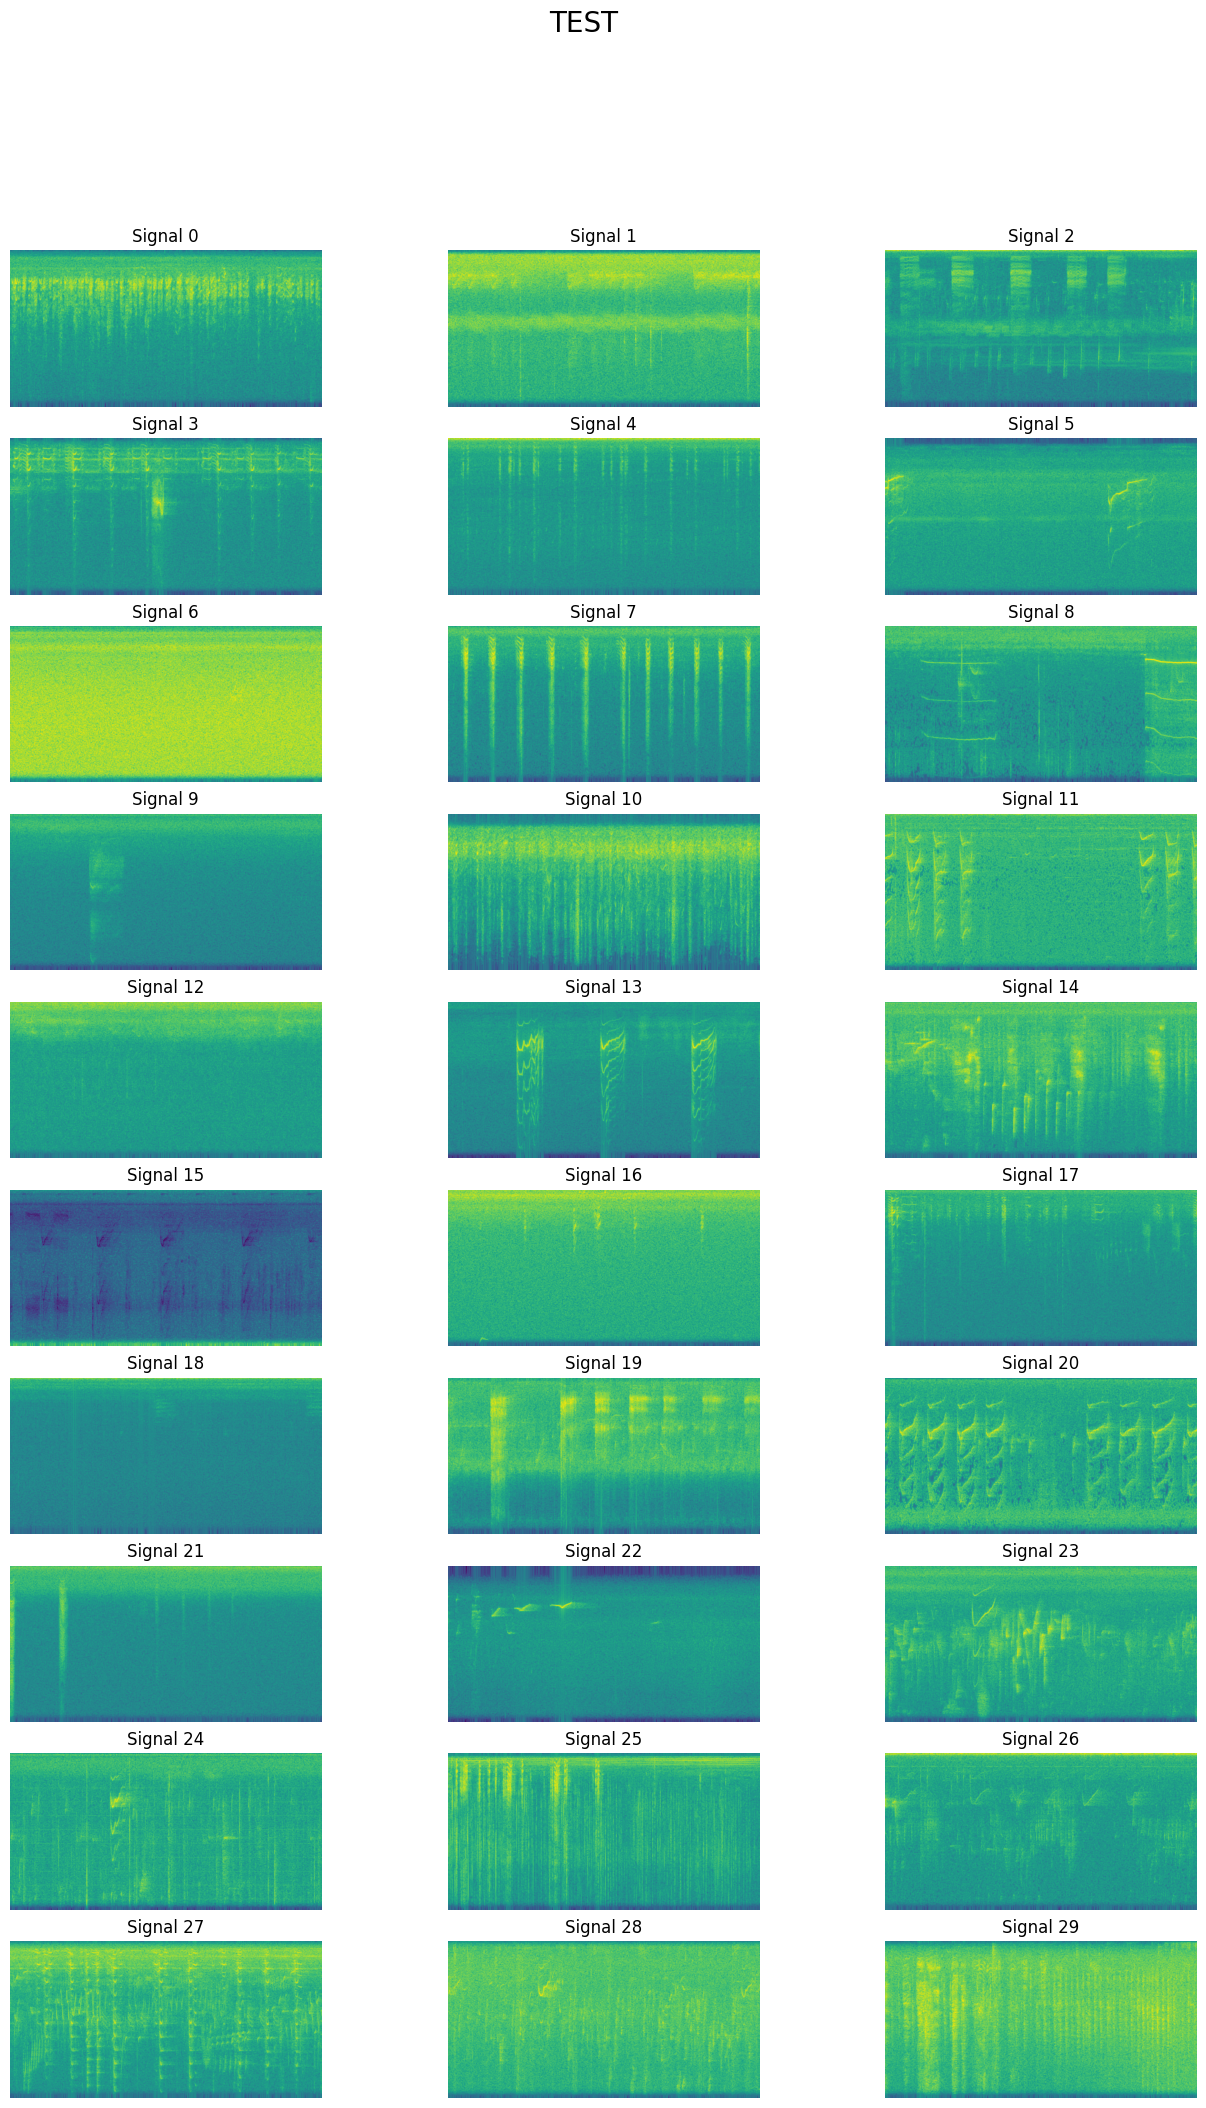

In [20]:
plot_spectrograms(signals.numpy(), 'TEST')